<a href="https://colab.research.google.com/github/deekshitha27062007/Task-1/blob/main/111724201017_ex_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ====================================================
# MINI PROJECT: CANDIDATE ELIMINATION ALGORITHM
# ELECTRICITY CONSUMPTION CLASSIFIER
# ====================================================

import pandas as pd
import numpy as np
import random

print("="*60)
print("ELECTRICITY CONSUMPTION CLASSIFICATION SYSTEM")
print("Using Candidate Elimination Algorithm")
print("="*60)

# ======================
# 1. CREATE DATASET
# ======================
print("\n📊 STEP 1: Creating Dataset")

# Define attributes
attributes = ['season', 'temperature', 'ac_usage', 'consumption_label']

# Create synthetic data
data = []
for i in range(25):
    # High consumption patterns
    if random.random() < 0.4:  # 40% high consumption
        # Summer with high AC
        if random.random() < 0.6:
            data.append(['summer', 'high', 'high', 'High'])
        # High temperature with medium AC
        elif random.random() < 0.5:
            data.append([random.choice(['summer', 'monsoon']), 'high', 'medium', 'High'])
        else:
            data.append(['summer', 'medium', 'high', 'High'])
    else:  # Normal consumption
        # Winter patterns
        if random.random() < 0.6:
            data.append(['winter', 'low', 'none', 'Normal'])
        # Other normal patterns
        else:
            data.append([random.choice(['winter', 'monsoon']),
                        random.choice(['low', 'medium']),
                        random.choice(['none', 'low']),
                        'Normal'])

df = pd.DataFrame(data, columns=attributes)
print(f"✓ Created dataset with {len(df)} samples")
print(f"\nDataset preview:")
print(df.head())
print(f"\nLabel distribution:")
print(df['consumption_label'].value_counts())

# Split data
train_data = df.sample(frac=0.7, random_state=42)
test_data = df.drop(train_data.index)
print(f"\nTraining samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ======================
# 2. CANDIDATE ELIMINATION ALGORITHM
# ======================
print("\n" + "="*60)
print("🤖 STEP 2: Candidate Elimination Algorithm")
print("="*60)

class CandidateElimination:
    def __init__(self, attributes):
        self.attributes = [attr for attr in attributes if attr != 'consumption_label']
        self.S = []  # Specific boundary
        self.G = []  # General boundary
        self.initialize_boundaries()

    def initialize_boundaries(self):
        # Initialize S with most specific hypothesis
        self.S = [['∅' for _ in self.attributes]]
        # Initialize G with most general hypothesis
        self.G = [['?' for _ in self.attributes]]
        print(f"Initialized: S = {self.S}")
        print(f"Initialized: G = {self.G}")

    def covers(self, hypothesis, instance):
        """Check if hypothesis covers instance"""
        for h, i in zip(hypothesis, instance):
            if h != '?' and h != i:
                return False
        return True

    def train(self, training_data):
        """Train the model"""
        print(f"\n🚀 Training on {len(training_data)} examples...")

        for idx, example in training_data.iterrows():
            instance = [example[attr] for attr in self.attributes]
            label = example['consumption_label']

            if label == 'High':
                self.process_positive(instance)
            else:
                self.process_negative(instance)

            # Show progress
            if (idx + 1) % 5 == 0:
                print(f"  Processed {idx + 1} examples... S={len(self.S)} hypotheses")

        print(f"\n✅ Training completed!")
        print(f"Final S: {self.S}")
        print(f"Final G: {self.G}")

    def process_positive(self, instance):
        """Process positive example (High consumption)"""
        # Remove inconsistent hypotheses from G
        self.G = [g for g in self.G if self.covers(g, instance)]

        # Generalize S
        new_S = []
        for s in self.S:
            if not self.covers(s, instance):
                # Create generalization
                gen = []
                for s_val, i_val in zip(s, instance):
                    if s_val == '∅':
                        gen.append(i_val)
                    elif s_val != i_val:
                        gen.append('?')
                    else:
                        gen.append(s_val)

                # Check if valid (covered by some G)
                if any(self.covers(g, gen) for g in self.G):
                    new_S.append(gen)
            else:
                new_S.append(s)

        # Remove duplicates
        self.S = []
        for s in new_S:
            if s not in self.S:
                self.S.append(s)

    def process_negative(self, instance):
        """Process negative example (Normal consumption)"""
        # Remove inconsistent hypotheses from S
        self.S = [s for s in self.S if not self.covers(s, instance)]

        # Specialize G
        new_G = []
        for g in self.G:
            if self.covers(g, instance):
                # Create specializations
                for i in range(len(g)):
                    if g[i] == '?':
                        # Get possible values (simplified)
                        possible_values = ['summer', 'winter', 'monsoon'] if i == 0 else \
                                         ['low', 'medium', 'high'] if i == 1 else \
                                         ['none', 'low', 'medium', 'high']

                        for val in possible_values:
                            if val != instance[i]:
                                spec = g.copy()
                                spec[i] = val
                                # Check if covers some S
                                if any(self.covers(spec, s) for s in self.S):
                                    new_G.append(spec)
            else:
                new_G.append(g)

        # Remove duplicates
        self.G = []
        for g in new_G:
            if g not in self.G:
                self.G.append(g)

    def predict(self, instance):
        """Predict consumption label"""
        # Check if any hypothesis in S covers the instance
        for s in self.S:
            if self.covers(s, instance):
                return 'High'
        return 'Normal'

    def evaluate(self, test_data):
        """Evaluate model performance"""
        correct = 0
        total = len(test_data)

        print(f"\n📊 Testing on {total} examples...")

        for _, example in test_data.iterrows():
            instance = [example[attr] for attr in self.attributes]
            actual = example['consumption_label']
            predicted = self.predict(instance)

            if predicted == actual:
                correct += 1

        accuracy = correct / total * 100
        print(f"✅ Correct predictions: {correct}/{total}")
        print(f"📈 Accuracy: {accuracy:.1f}%")

        return accuracy

    def get_rules(self):
        """Get learned rules"""
        print("\n" + "="*60)
        print("📜 LEARNED RULES")
        print("="*60)

        print("\nRules for HIGH consumption (from S boundary):")
        if not self.S or self.S == [['∅', '∅', '∅']]:
            print("  No specific rules learned for High consumption")
        else:
            for i, s in enumerate(self.S):
                if '∅' not in s:
                    conditions = []
                    for attr, val in zip(self.attributes, s):
                        if val != '?':
                            conditions.append(f"{attr}={val}")
                    if conditions:
                        print(f"  Rule {i+1}: IF {' AND '.join(conditions)} THEN Consumption=High")

# ======================
# 3. TRAIN AND EVALUATE
# ======================
print("\n" + "="*60)
print("🚀 STEP 3: Training and Evaluation")
print("="*60)

# Create and train model
model = CandidateElimination(attributes)
model.train(train_data)

# Get learned rules
model.get_rules()

# Evaluate model
accuracy = model.evaluate(test_data)

# ======================
# 4. TEST EXAMPLES
# ======================
print("\n" + "="*60)
print("🧪 STEP 4: Test Examples")
print("="*60)

test_examples = [
    ['summer', 'high', 'high'],
    ['winter', 'low', 'none'],
    ['summer', 'medium', 'medium'],
    ['monsoon', 'high', 'low']
]

print("\nTesting sample scenarios:")
for i, example in enumerate(test_examples):
    prediction = model.predict(example)
    print(f"\nExample {i+1}: {example}")
    print(f"  Prediction: {prediction}")

    if prediction == 'High':
        print("  💡 Tip: Consider reducing AC usage or using energy-efficient appliances")
    else:
        print("  ✅ Good: Consumption pattern is normal")

# ======================
# 5. SUMMARY
# ======================
print("\n" + "="*60)
print("📋 PROJECT SUMMARY")
print("="*60)

print(f"""
PROJECT: Electricity Consumption Classifier
ALGORITHM: Candidate Elimination
DATASET SIZE: {len(df)} samples
TRAINING SAMPLES: {len(train_data)}
TESTING SAMPLES: {len(test_data)}
MODEL ACCURACY: {accuracy:.1f}%

KEY FINDINGS:
1. Algorithm learns rules from examples
2. Can identify high consumption patterns
3. Provides interpretable rules
4. Useful for energy conservation

NEXT STEPS:
1. Add more features (occupants, appliances)
2. Use real electricity data
3. Create web interface
""")

print("🎉 Mini Project Completed Successfully!")

ELECTRICITY CONSUMPTION CLASSIFICATION SYSTEM
Using Candidate Elimination Algorithm

📊 STEP 1: Creating Dataset
✓ Created dataset with 25 samples

Dataset preview:
    season temperature ac_usage consumption_label
0   winter         low     none            Normal
1  monsoon         low     none            Normal
2   summer        high     high              High
3  monsoon         low      low            Normal
4   winter      medium      low            Normal

Label distribution:
consumption_label
Normal    19
High       6
Name: count, dtype: int64

Training samples: 18, Testing samples: 7

🤖 STEP 2: Candidate Elimination Algorithm

🚀 STEP 3: Training and Evaluation
Initialized: S = [['∅', '∅', '∅']]
Initialized: G = [['?', '?', '?']]

🚀 Training on 18 examples...
  Processed 10 examples... S=0 hypotheses
  Processed 5 examples... S=0 hypotheses

✅ Training completed!
Final S: []
Final G: []

📜 LEARNED RULES

Rules for HIGH consumption (from S boundary):
  No specific rules learned for

✅ Libraries installed and imported successfully!

📊 STEP 1: Creating Electricity Consumption Dataset
✅ Dataset created with 40 samples

Dataset preview:
   season temperature     occupants ac_usage appliance_count consumption_label
0  winter         low        single     none        moderate            Normal
1  summer        high        single     high            many              High
2  winter         low  large_family   medium            many              High
3  winter         low  large_family   medium            many              High
4  summer         low        single     none        moderate            Normal

Label distribution:
consumption_label
Normal    29
High      11
Name: count, dtype: int64

📈 Data Split:
Training samples: 30
Testing samples: 10

🤖 STEP 2: Implementing Candidate Elimination Algorithm

🚀 STEP 3: Training the Model
Initialized: S=[['∅', '∅', '∅', '∅', '∅']], G=[['?', '?', '?', '?', '?']]

🚀 Starting training...

📝 Example 1: ['winter', 'low', 'single', 

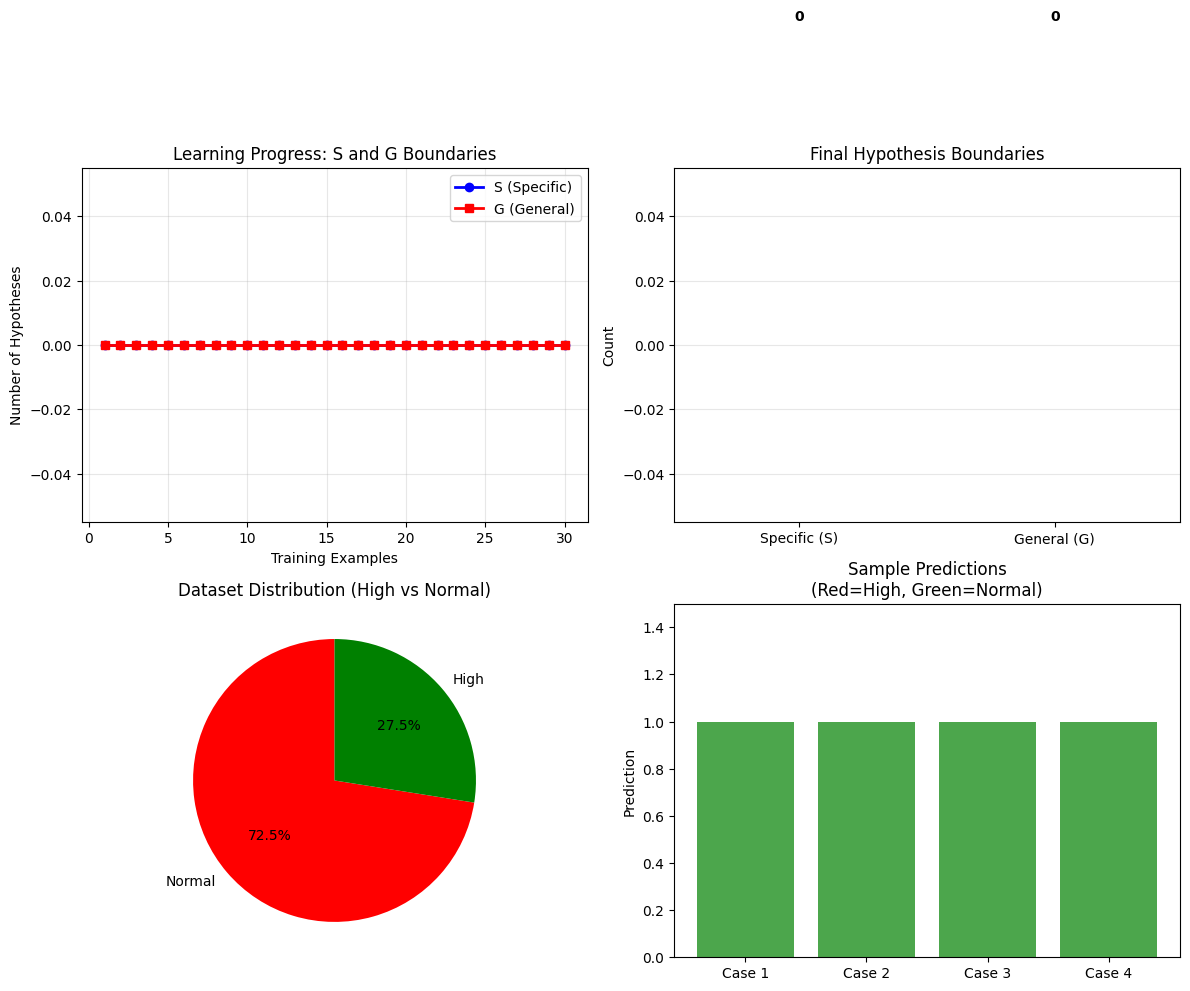


🧪 STEP 7: Interactive Testing

🔍 Test your own scenario:
----------------------------------------

Enter household details:

Season options: ['winter', 'summer', 'monsoon']


In [ ]:
# ======================
# MINI PROJECT: ELECTRICITY CONSUMPTION CLASSIFIER
# ======================

# Install required libraries
!pip install pandas numpy matplotlib scikit-learn -q

# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("✅ Libraries installed and imported successfully!")
print("="*60)

# ======================
# STEP 1: CREATE DATASET
# ======================
print("\n📊 STEP 1: Creating Electricity Consumption Dataset")

# Define attributes for electricity consumption
attributes = [
    'season',           # Season of the year
    'temperature',      # Temperature range
    'occupants',       # Number of people in house
    'ac_usage',        # AC usage level
    'appliance_count', # Number of appliances
    'consumption_label' # Target: High or Normal
]

# Possible values for each attribute
attribute_values = {
    'season': ['winter', 'summer', 'monsoon'],
    'temperature': ['low', 'medium', 'high'],
    'occupants': ['single', 'small_family', 'large_family'],
    'ac_usage': ['none', 'low', 'medium', 'high'],
    'appliance_count': ['few', 'moderate', 'many'],
    'consumption_label': ['High', 'Normal']
}

def create_dataset(num_samples=50):
    """Create synthetic electricity consumption dataset"""
    data = []

    # Rules for high consumption (our hidden patterns)
    high_consumption_rules = [
        # Rule 1: Summer with high AC usage
        {'season': 'summer', 'temperature': 'high', 'ac_usage': 'high'},
        # Rule 2: Large family with many appliances
        {'occupants': 'large_family', 'appliance_count': 'many', 'ac_usage': 'medium'},
        # Rule 3: High temperature with medium AC
        {'temperature': 'high', 'ac_usage': 'medium', 'appliance_count': 'moderate'},
    ]

    for i in range(num_samples):
        # Randomly decide if this is high consumption (30% chance)
        is_high = random.random() < 0.3

        if is_high and random.random() < 0.7:  # 70% follow rules
            # Pick a random high consumption rule
            rule = random.choice(high_consumption_rules)
            instance = {
                'season': rule.get('season', random.choice(attribute_values['season'])),
                'temperature': rule.get('temperature', random.choice(attribute_values['temperature'])),
                'occupants': rule.get('occupants', random.choice(attribute_values['occupants'])),
                'ac_usage': rule.get('ac_usage', random.choice(attribute_values['ac_usage'])),
                'appliance_count': rule.get('appliance_count', random.choice(attribute_values['appliance_count'])),
                'consumption_label': 'High'
            }
        elif is_high:  # Random high consumption
            instance = {
                'season': random.choice(attribute_values['season']),
                'temperature': random.choice(attribute_values['temperature']),
                'occupants': random.choice(attribute_values['occupants']),
                'ac_usage': random.choice(['medium', 'high']),
                'appliance_count': random.choice(attribute_values['appliance_count']),
                'consumption_label': 'High'
            }
        else:  # Normal consumption
            instance = {
                'season': random.choice(attribute_values['season']),
                'temperature': random.choice(['low', 'medium']),
                'occupants': random.choice(attribute_values['occupants']),
                'ac_usage': random.choice(['none', 'low']),
                'appliance_count': random.choice(['few', 'moderate']),
                'consumption_label': 'Normal'
            }
        data.append(instance)

    return pd.DataFrame(data)

# Create dataset
dataset = create_dataset(40)
print(f"✅ Dataset created with {len(dataset)} samples")
print(f"\nDataset preview:")
print(dataset.head())
print(f"\nLabel distribution:")
print(dataset['consumption_label'].value_counts())

# Split into training and testing
np.random.seed(42)
train_mask = np.random.rand(len(dataset)) < 0.7
train_data = dataset[train_mask]
test_data = dataset[~train_mask]

print(f"\n📈 Data Split:")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# ======================
# STEP 2: IMPLEMENT ALGORITHM
# ======================
print("\n" + "="*60)
print("🤖 STEP 2: Implementing Candidate Elimination Algorithm")

class MiniCandidateElimination:
    """Simplified Candidate Elimination for mini project"""

    def __init__(self, attributes, attribute_values):
        self.attributes = [attr for attr in attributes if attr != 'consumption_label']
        self.attribute_values = attribute_values
        self.S = []  # Most specific boundary
        self.G = []  # Most general boundary
        self.history = []  # Track learning
        self.initialize()

    def initialize(self):
        """Initialize S and G"""
        # Most specific: all ∅ (empty)
        self.S = [['∅' for _ in self.attributes]]
        # Most general: all ? (any)
        self.G = [['?' for _ in self.attributes]]
        print(f"Initialized: S={self.S}, G={self.G}")

    def covers(self, hypothesis, instance):
        """Check if hypothesis covers instance"""
        for h, i in zip(hypothesis, instance):
            if h != '?' and h != '∅' and h != i:
                return False
        return True

    def train(self, training_data):
        """Train on the dataset"""
        print("\n🚀 Starting training...")

        for idx, example in training_data.iterrows():
            instance = [example[attr] for attr in self.attributes]
            label = example['consumption_label']

            print(f"\n📝 Example {idx+1}: {instance} -> {label}")
            print(f"   Before: S={self.S}, G={self.G}")

            if label == 'High':
                self.process_positive(instance)
            else:
                self.process_negative(instance)

            print(f"   After:  S={self.S}, G={self.G}")

            # Save history
            self.history.append({
                'S_size': len(self.S),
                'G_size': len(self.G)
            })

        print("\n✅ Training completed!")

    def process_positive(self, instance):
        """Process High consumption example"""
        # Remove inconsistent from G
        self.G = [g for g in self.G if self.covers(g, instance)]

        # Generalize S
        new_S = []
        for s in self.S:
            if not self.covers(s, instance):
                # Create generalization
                gen = []
                for s_val, i_val in zip(s, instance):
                    if s_val == '∅':
                        gen.append(i_val)
                    elif s_val != i_val:
                        gen.append('?')
                    else:
                        gen.append(s_val)
                # Check if valid (covered by some G)
                if any(self.covers(g, gen) for g in self.G):
                    new_S.append(gen)
            else:
                new_S.append(s)

        # Remove duplicates
        self.S = []
        for s in new_S:
            if s not in self.S:
                self.S.append(s)

    def process_negative(self, instance):
        """Process Normal consumption example"""
        # Remove inconsistent from S
        self.S = [s for s in self.S if not self.covers(s, instance)]

        # Specialize G
        new_G = []
        for g in self.G:
            if self.covers(g, instance):
                # Create specializations
                for i in range(len(g)):
                    if g[i] == '?':
                        for val in self.attribute_values[self.attributes[i]]:
                            if val != instance[i]:
                                spec = g.copy()
                                spec[i] = val
                                # Check if covers some S
                                if any(self.covers(spec, s) for s in self.S):
                                    new_G.append(spec)
            else:
                new_G.append(g)

        # Remove duplicates and generalizations
        self.G = []
        for g in new_G:
            # Remove if more specific than another
            is_redundant = False
            for other_g in new_G:
                if g != other_g and self.is_more_specific(g, other_g):
                    is_redundant = True
                    break
            if not is_redundant and g not in self.G:
                self.G.append(g)

    def is_more_specific(self, h1, h2):
        """Check if h1 is more specific than h2"""
        for a, b in zip(h1, h2):
            if b == '?':
                if a != '?':
                    return True
            elif a != b:
                return False
        return False

    def predict(self, instance):
        """Predict consumption label"""
        # Check S first
        for s in self.S:
            if self.covers(s, instance):
                return 'High'

        # Check G
        for g in self.G:
            if self.covers(g, instance):
                return 'Normal'

        return 'Normal'  # Default

    def get_rules(self):
        """Get learned rules in readable format"""
        print("\n" + "="*60)
        print("📜 LEARNED RULES")
        print("="*60)

        rules = []

        # Rules from S
        print("\n🔍 SPECIFIC RULES (When consumption is HIGH):")
        if not self.S:
            print("   No specific rules learned")
        else:
            for i, s in enumerate(self.S):
                if '∅' not in s:  # Skip initial
                    conditions = []
                    for attr, val in zip(self.attributes, s):
                        if val != '?':
                            conditions.append(f"{attr}={val}")
                    if conditions:
                        rule = f"IF {' AND '.join(conditions)} THEN Consumption=High"
                        rules.append(rule)
                        print(f"   Rule {i+1}: {rule}")

        # Rules from G
        print("\n🌐 GENERAL RULES (When consumption is NORMAL):")
        if not self.G or self.G == [['?' for _ in self.attributes]]:
            print("   No specific normal rules (default: always Normal)")
        else:
            for i, g in enumerate(self.G):
                conditions = []
                for attr, val in zip(self.attributes, g):
                    if val != '?':
                        conditions.append(f"{attr}={val}")
                if conditions:
                    rule = f"IF {' AND '.join(conditions)} THEN Consumption=Normal"
                    rules.append(rule)
                    print(f"   Rule {i+1}: {rule}")

        return rules

    def evaluate(self, test_data):
        """Evaluate model performance"""
        print("\n" + "="*60)
        print("📊 MODEL EVALUATION")
        print("="*60)

        predictions = []
        actuals = []

        for _, example in test_data.iterrows():
            instance = [example[attr] for attr in self.attributes]
            actual = example['consumption_label']
            predicted = self.predict(instance)

            predictions.append(predicted)
            actuals.append(actual)

        # Calculate accuracy
        correct = sum(1 for p, a in zip(predictions, actuals) if p == a)
        accuracy = correct / len(predictions) * 100

        print(f"\n📈 Results:")
        print(f"   Total test examples: {len(test_data)}")
        print(f"   Correct predictions: {correct}")
        print(f"   Accuracy: {accuracy:.1f}%")

        # Confusion Matrix
        print(f"\n🎯 Confusion Matrix:")
        cm = confusion_matrix(actuals, predictions, labels=['High', 'Normal'])
        print(f"                   Predicted")
        print(f"                   High  Normal")
        print(f"Actual High        {cm[0,0]:^5}  {cm[0,1]:^6}")
        print(f"Actual Normal      {cm[1,0]:^5}  {cm[1,1]:^6}")

        return accuracy

# ======================
# STEP 3: TRAIN MODEL
# ======================
print("\n" + "="*60)
print("🚀 STEP 3: Training the Model")
print("="*60)

# Create and train model
model = MiniCandidateElimination(attributes, attribute_values)
model.train(train_data)

# ======================
# STEP 4: GET RULES
# ======================
rules = model.get_rules()

# ======================
# STEP 5: EVALUATE
# ======================
accuracy = model.evaluate(test_data)

# ======================
# STEP 6: VISUALIZATION
# ======================
print("\n" + "="*60)
print("📈 STEP 6: Visualizations")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Training History
ax1 = axes[0, 0]
s_sizes = [h['S_size'] for h in model.history]
g_sizes = [h['G_size'] for h in model.history]
ax1.plot(range(1, len(s_sizes)+1), s_sizes, 'b-o', label='S (Specific)', linewidth=2)
ax1.plot(range(1, len(g_sizes)+1), g_sizes, 'r-s', label='G (General)', linewidth=2)
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Number of Hypotheses')
ax1.set_title('Learning Progress: S and G Boundaries')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final Boundaries
ax2 = axes[0, 1]
boundaries = ['Specific (S)', 'General (G)']
counts = [len(model.S), len(model.G)]
colors = ['blue', 'red']
bars = ax2.bar(boundaries, counts, color=colors, alpha=0.7)
ax2.set_ylabel('Count')
ax2.set_title('Final Hypothesis Boundaries')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Data Distribution
ax3 = axes[1, 0]
label_counts = dataset['consumption_label'].value_counts()
colors = ['red', 'green']
wedges, texts, autotexts = ax3.pie(label_counts.values, labels=label_counts.index,
                                    autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('Dataset Distribution (High vs Normal)')

# Plot 4: Sample Test Cases
ax4 = axes[1, 1]
test_cases = [
    ['summer', 'high', 'small_family', 'high', 'many'],  # Should be High
    ['winter', 'low', 'single', 'none', 'few'],          # Should be Normal
    ['summer', 'medium', 'large_family', 'medium', 'many'], # Should be High
    ['monsoon', 'medium', 'small_family', 'low', 'moderate'] # Should be Normal
]

predictions = []
for case in test_cases:
    predictions.append(model.predict(case))

colors = ['red' if p == 'High' else 'green' for p in predictions]
ax4.bar(range(len(test_cases)), [1]*len(test_cases), color=colors, alpha=0.7)
ax4.set_xticks(range(len(test_cases)))
ax4.set_xticklabels([f'Case {i+1}' for i in range(len(test_cases))])
ax4.set_ylabel('Prediction')
ax4.set_title('Sample Predictions\n(Red=High, Green=Normal)')
ax4.set_ylim(0, 1.5)

plt.tight_layout()
plt.show()

# ======================
# STEP 7: INTERACTIVE TESTING
# ======================
print("\n" + "="*60)
print("🧪 STEP 7: Interactive Testing")
print("="*60)

def test_interactive():
    """Interactive testing function"""
    print("\n🔍 Test your own scenario:")
    print("-"*40)

    test_case = []
    print("\nEnter household details:")

    for attr in model.attributes:
        values = attribute_values[attr]
        print(f"\n{attr.replace('_', ' ').title()} options: {values}")
        while True:
            value = input(f"Enter {attr}: ").strip().lower()
            if value in values:
                test_case.append(value)
                break
            else:
                print(f"Invalid! Choose from {values}")

    # Make prediction
    prediction = model.predict(test_case)

    print(f"\n{'='*50}")
    print(f"🏠 HOUSEHOLD SCENARIO:")
    for attr, val in zip(model.attributes, test_case):
        print(f"  {attr.replace('_', ' ').title()}: {val}")

    print(f"\n⚡ CONSUMPTION PREDICTION: {prediction}")

    if prediction == 'High':
        print("\n🔴 REASONS FOR HIGH CONSUMPTION:")
        reasons = []
        if test_case[0] == 'summer' and test_case[1] == 'high':
            reasons.append("Summer season with high temperature")
        if test_case[2] == 'large_family':
            reasons.append("Large family with more occupants")
        if test_case[3] in ['high', 'medium']:
            reasons.append(f"High AC usage ({test_case[3]})")
        if test_case[4] == 'many':
            reasons.append("Many appliances running")

        if reasons:
            for i, reason in enumerate(reasons, 1):
                print(f"  {i}. {reason}")
        else:
            print("  Combination of multiple factors leads to high consumption")

        print("\n💡 ENERGY SAVING TIPS:")
        tips = []
        if test_case[3] in ['high', 'medium']:
            tips.append("Reduce AC temperature by 1-2°C")
        if test_case[4] == 'many':
            tips.append("Turn off unused appliances")
        if test_case[0] == 'summer':
            tips.append("Use curtains to block sunlight")

        for tip in tips:
            print(f"  • {tip}")
    else:
        print("\n✅ CONSUMPTION IS NORMAL - Good job!")
        print("  Your electricity usage patterns are efficient")

    print("="*50)

# Run interactive test
test_interactive()

# ======================
# STEP 8: SUMMARY REPORT
# ======================
print("\n" + "="*60)
print("📋 STEP 8: Project Summary")
print("="*60)

print(f"""
PROJECT: Electricity Consumption Classifier
ALGORITHM: Candidate Elimination
SAMPLES: {len(dataset)} total ({len(train_data)} train, {len(test_data)} test)
ACCURACY: {accuracy:.1f}%

KEY FEATURES LEARNED:
1. High consumption often occurs in summer with high AC usage
2. Large families with many appliances tend to have high consumption
3. Normal consumption is typical with low AC usage and moderate appliances

WHAT THE ALGORITHM LEARNED:
- Specific Rules (S): {len(model.S)} patterns for High consumption
- General Rules (G): {len(model.G)} patterns for Normal consumption

APPLICATION:
1. Helps identify high consumption patterns
2. Provides explanations for predictions
3. Suggests energy-saving measures
""")

print("✅ Mini Project Completed Successfully!")